# Get data from kaggle

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [4]:
! cp /content/drive/MyDrive/Kaggle/kaggle.json ~/.kaggle/

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
! kaggle datasets download puneet6060/intel-image-classification

intel-image-classification.zip: Skipping, found more recently modified local copy (use --force to force download)


In [7]:
! unzip intel-image-classification.zip

Streaming output truncated to the last 5000 lines.
  inflating: seg_train/seg_train/mountain/7506.jpg  
  inflating: seg_train/seg_train/mountain/7537.jpg  
  inflating: seg_train/seg_train/mountain/7539.jpg  
  inflating: seg_train/seg_train/mountain/7551.jpg  
  inflating: seg_train/seg_train/mountain/7560.jpg  
  inflating: seg_train/seg_train/mountain/7565.jpg  
  inflating: seg_train/seg_train/mountain/7578.jpg  
  inflating: seg_train/seg_train/mountain/7581.jpg  
  inflating: seg_train/seg_train/mountain/7586.jpg  
  inflating: seg_train/seg_train/mountain/7647.jpg  
  inflating: seg_train/seg_train/mountain/7652.jpg  
  inflating: seg_train/seg_train/mountain/7654.jpg  
  inflating: seg_train/seg_train/mountain/7662.jpg  
  inflating: seg_train/seg_train/mountain/767.jpg  
  inflating: seg_train/seg_train/mountain/7672.jpg  
  inflating: seg_train/seg_train/mountain/7679.jpg  
  inflating: seg_train/seg_train/mountain/7681.jpg  
  inflating: seg_train/seg_train/mountain/7693.jp

# Library

In [8]:
import tensorflow as tf
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet201
from keras.layers import Input
from keras import layers
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import numpy as np
import matplotlib.pyplot as plt
import pathlib

# Data Preprocessing

In [9]:
train_dir = '/content/seg_train/seg_train'

## Image Generator

In [10]:
datagen = ImageDataGenerator(
    rescale=1/255.,
    rotation_range=30,
    shear_range=0.2,
    zoom_range=0.2,
    vertical_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150), 
    batch_size=32,
    shuffle=True,
    subset='training',
    class_mode='categorical'
)

validation_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    shuffle=False,
    subset='validation',
    class_mode='categorical'
)

Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.


In [11]:
train_generator.class_indices

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

In [12]:
validation_generator.class_indices

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

## Visualize dataset

In [13]:
class_names = ['mountain', 'street', 'glacier', 'buildings', 'sea', 'forest']

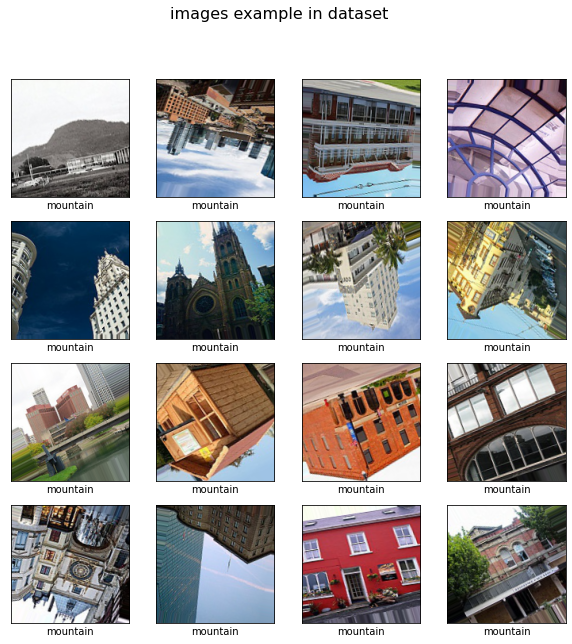

In [14]:
x,y = validation_generator.next()

label = np.argmax(y, axis=1)
fig = plt.figure(figsize=(10,10))
fig.suptitle("images example in dataset", fontsize=16)
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[label[i]])
plt.show()

# Transfer Learning with DenseNet201

In [15]:
pre_trained_model = DenseNet201(weights='imagenet', include_top=False, input_tensor=Input(shape=(150, 150, 3)))

In [16]:
freeze_index = None
for i,layer in enumerate(pre_trained_model.layers):
    if 'conv4' in layer._name:
        freeze_index = i
        break
        
for layer in pre_trained_model.layers[:freeze_index]:
    layer.trainable = False

In [17]:
last_output = pre_trained_model.output
x = layers.GlobalAveragePooling2D()(last_output)
x = layers.Dense(512, activation='relu')(x)
outputs = layers.Dense(6, activation='softmax')(x)

model = tf.keras.models.Model(pre_trained_model.input, outputs)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 156, 156, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 75, 75, 64)   9408        ['zero_padding2d[0][0]']         
                                                                                                  
 conv1/bn (BatchNormalization)  (None, 75, 75, 64)   256         ['conv1/conv[0][0]']         

In [18]:
num_epochs = 15
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [19]:
# earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.3, 
                                            min_lr=0.00000001)

## Train Model

In [20]:
H = model.fit(train_generator,
              epochs=num_epochs,
              validation_data=validation_generator, callbacks=[learning_rate_reduction])

Epoch 1/15
351/351 [==============================] - 135s 317ms/step - loss: 0.4256 - accuracy: 0.8495 - val_loss: 0.3119 - val_accuracy: 0.8852 - lr: 1.0000e-04
Epoch 2/15
351/351 [==============================] - 95s 271ms/step - loss: 0.2588 - accuracy: 0.9079 - val_loss: 0.2581 - val_accuracy: 0.9083 - lr: 1.0000e-04
Epoch 3/15
351/351 [==============================] - 95s 271ms/step - loss: 0.2039 - accuracy: 0.9284 - val_loss: 0.2595 - val_accuracy: 0.9144 - lr: 1.0000e-04
Epoch 4/15
351/351 [==============================] - 95s 270ms/step - loss: 0.1673 - accuracy: 0.9413 - val_loss: 0.2720 - val_accuracy: 0.9044 - lr: 1.0000e-04
Epoch 5/15
351/351 [==============================] - ETA: 0s - loss: 0.1404 - accuracy: 0.9500
Epoch 5: ReduceLROnPlateau reducing learning rate to 2.9999999242136255e-05.
351/351 [==============================] - 95s 271ms/step - loss: 0.1404 - accuracy: 0.9500 - val_loss: 0.2725 - val_accuracy: 0.9158 - lr: 1.0000e-04
Epoch 6/15
351/351 [=======

# Learning Plot

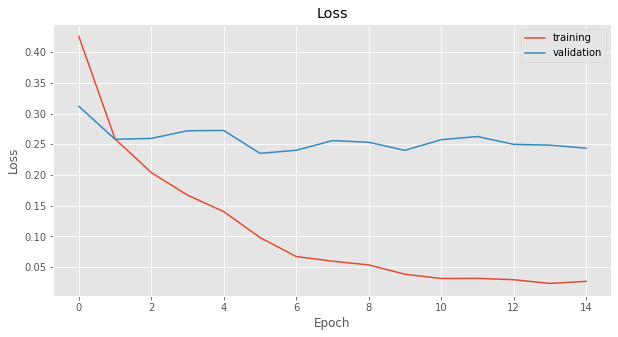

In [21]:
plt.style.use("ggplot")
plt.figure(figsize=(10, 5))
plt.plot(np.arange(0, 15), H.history["loss"], label="training")
plt.plot(np.arange(0, 15), H.history["val_loss"], label="validation")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

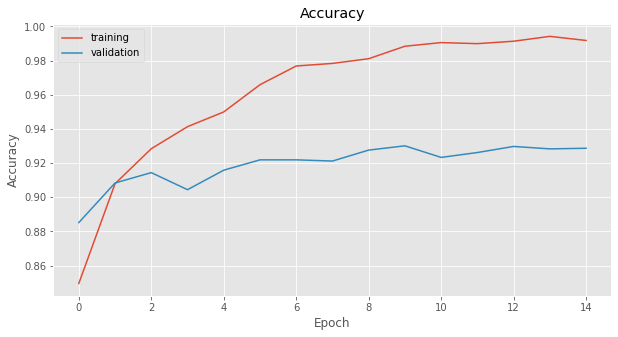

In [22]:
plt.figure(figsize=(10, 5))
plt.plot(np.arange(0, num_epochs), H.history["accuracy"], label="training")
plt.plot(np.arange(0, num_epochs), H.history["val_accuracy"], label="validation")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Convert Model to TFLite

In [23]:
export_dir = 'saved_model/'
tf.saved_model.save(model, export_dir)

In [24]:
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

In [25]:
tflite_model_file = pathlib.Path('vegs.tflite')
tflite_model_file.write_bytes(tflite_model)

76432956